In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from time import time
from decimal import Decimal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
### import TRAINING ref failures
tic = time()

rf_signals = pd.read_excel('./Training/all_fail/ref_failures_ATData.xlsx')
rf_bubble_detect = pd.read_excel('./Training/all_fail/ref_failures_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 614.102s


In [ ]:
### import TESTING ref failures
tic = time()

rf_signals = pd.read_excel('./Testing/ref_failures/ref_failures_ATData.xlsx')
rf_bubble_detect = pd.read_excel('./Testing/ref_failures/ref_failures_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

In [3]:
class Test:
    def __init__(self, ID, BubbleDetectTime, P4, P5, A4):
        self.ID = ID
        self.BubbleDetectTime = BubbleDetectTime
        self.P4 = P4 # potassium
        self.P5 = P5 # calcium
        self.A4 = A4 # crea
        
    # function to offset t = 0
    def offset_time(self):
        # using Decimal due to rounding error
        t_0 = Decimal(str(self.BubbleDetectTime + 30))
        t_step = Decimal(str(0.2))
        start_idx = round(t_0/t_step) - 1
                
        self.P4 = self.P4[start_idx:]
        self.P5 = self.P5[start_idx:]
        self.A4 = self.A4[start_idx:]
        
    # function to trim NaNs
    def trim_NaNs(self):
        # making sure list is not empty
        while len(self.P4) > 0 and math.isnan(self.P4[-1]):
            self.P4.pop()
                
        while len(self.P5) > 0 and math.isnan(self.P5[-1]):
            self.P5.pop()
        
        while len(self.A4) > 0 and math.isnan(self.A4[-1]):
            self.A4.pop()

In [4]:
def create_test_list(signals, bubble_detect_time):
    # separating channels
    group_channels = signals.groupby('Channel')
    channel_dfs = {}

    # iterating over the groups and creating a new dataframe for each group
    for channel, group in group_channels:
        df = pd.DataFrame(group.iloc[:, 2:])
        channel_dfs[channel] = df

    # creating test objects
    tests = []
    for i in range(0, len(bubble_detect_time)):
        ID = bubble_detect_time.iloc[i, 0]
        BubbleDetectTime = bubble_detect_time.iloc[i, 1]
        P4 = channel_dfs['P4'].iloc[i, :].values.tolist()
        P5 = channel_dfs['P5'].iloc[i, :].values.tolist()
        A4 = channel_dfs['A4'].iloc[i, :].values.tolist()

        new_test = Test(ID, BubbleDetectTime, P4, P5, A4)
        tests.append(new_test)
    
    return tests

In [5]:
### making test objects 
rf_tests = create_test_list(rf_signals, rf_bubble_detect)

### offset and trim all tests
for test in rf_tests: 
    test.offset_time()
    test.trim_NaNs()

In [7]:
"""
# checking for empty tests
for test in rf_tests:
    if len(test.P4) == 0:
        print(test.ID)
"""

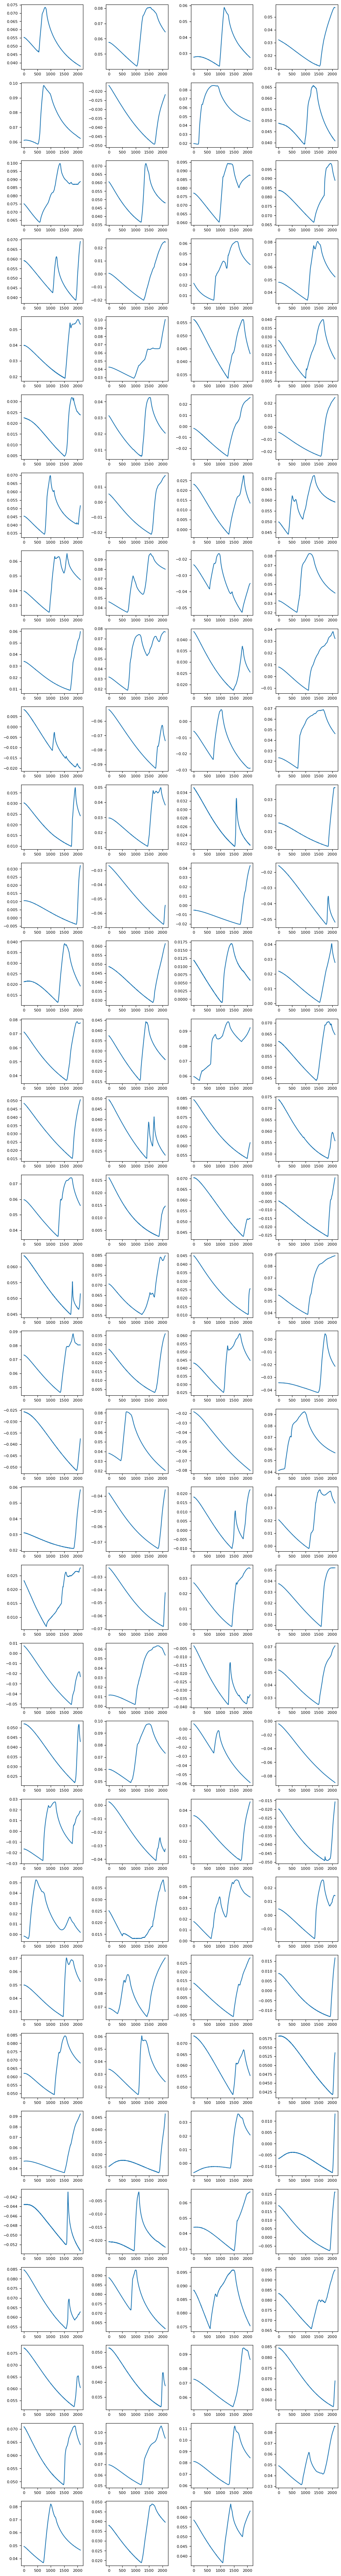

In [7]:
"""### plot for sanity check
i = 300
j = 431

# calculate grid dimensions
n_plots = len(rf_tests[i:j])
n_cols = 4
n_rows = int(np.ceil(n_plots/n_cols))

# create the figure and subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

# flatten the subplots array to make it easier to index
axs = axs.ravel()

# loop over the plots and generate them
for idx, test in enumerate(rf_tests[i:j]):
    axs[idx].plot(test.P4)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)

# hide any unused subplots
for i in range(n_plots, n_rows*n_cols):
    axs[i].axis('off')

# show the plots
plt.tight_layout()
plt.show()"""

In [9]:
def flag_peaks(tests):
    test_peaks = []

    for test in tests:
        # captures ref failures at end of signal
        # note: width=(100, 1400) also optimizes accuracy with 99.4% and 98.5%
        peaks, properties = find_peaks(-1*np.array(test.P4), width=10) 

        # """"
        if len(peaks) == 0:
            # check for ref failure at start of signal
            peaks, _ = find_peaks(np.array(test.P4), width=10) 
        # """

        test_peaks.append(peaks)
        
    return test_peaks

In [10]:
### finding peaks in ref failures
rf_peaks = flag_peaks(rf_tests)

In [11]:
### investigating ref failures w/ no peaks
print(len(rf_tests))
print(len(rf_peaks))

empty_peak_lists = []
for idx, peak_list in enumerate(rf_peaks):
    if len(peak_list) == 0:
        empty_peak_lists.append(idx)
        
print(len(empty_peak_lists))

2706
2706
10


In [12]:
### removing mislabelled tests
rf_tests_mislabelled = [16, 206, 218, 364, 340, 440]

empty_peak_lists = [peak_list for peak_list in empty_peak_lists if peak_list not in rf_tests_mislabelled]
print(empty_peak_lists)

[27, 37, 95, 284, 374, 391, 597, 598, 690, 692]


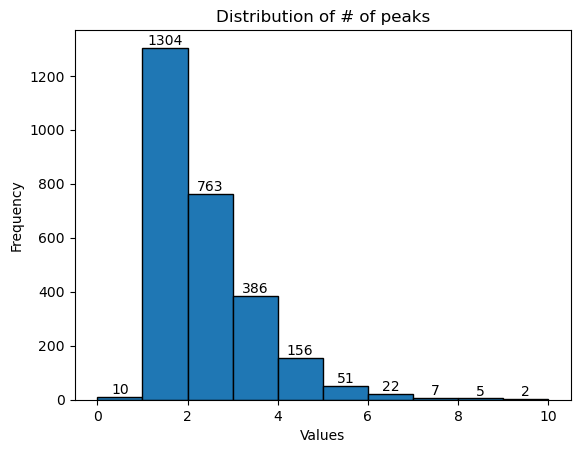

In [15]:
# checking distribution of # of peaks
len_peaks = [len(peaks) for peaks in rf_peaks]

bin_edges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# plotting distribution of std
counts, edges, bars = plt.hist(len_peaks, bins=bin_edges, edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.bar_label(bars)
plt.title('Distribution of # of peaks')

# show the plot
plt.show()

In [11]:
def plot_waveforms(target_indices, tests, test_peaks, channel):
    n_plots = len(target_indices)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for axs_num, idx in enumerate(target_indices):
        waveform = np.array(getattr(tests[idx], channel))
        peaks = test_peaks[idx]
        
        # plotting waveforms with peaks
        axs[axs_num].plot(waveform)
        axs[axs_num].plot(peaks, waveform[peaks], "x")
        axs[axs_num].tick_params(axis='both', which='major', labelsize=8)

    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
def plot_channel_diff(target_indices, tests):
    n_plots = len(target_indices)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for axs_num, idx in enumerate(target_indices):
        P4_array = np.array(tests[idx].P4)
        P5_array = np.array(tests[idx].P5)
        channel_diff = [x - y for x, y in zip(P4_array, P5_array)]
        
        print(np.std(channel_diff))
        
        # plotting waveforms with peaks
        axs[axs_num].plot(channel_diff)
        axs[axs_num].tick_params(axis='both', which='major', labelsize=8)

    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
def compute_noise(target_indices, tests):
    std = []
    
    for idx in target_indices:
        P4_array = np.array(tests[idx].P4)
        P5_array = np.array(tests[idx].P5)
        channel_diff = [x - y for x, y in zip(P4_array, P5_array)]
        
        std.append(np.std(channel_diff))
    
    return std

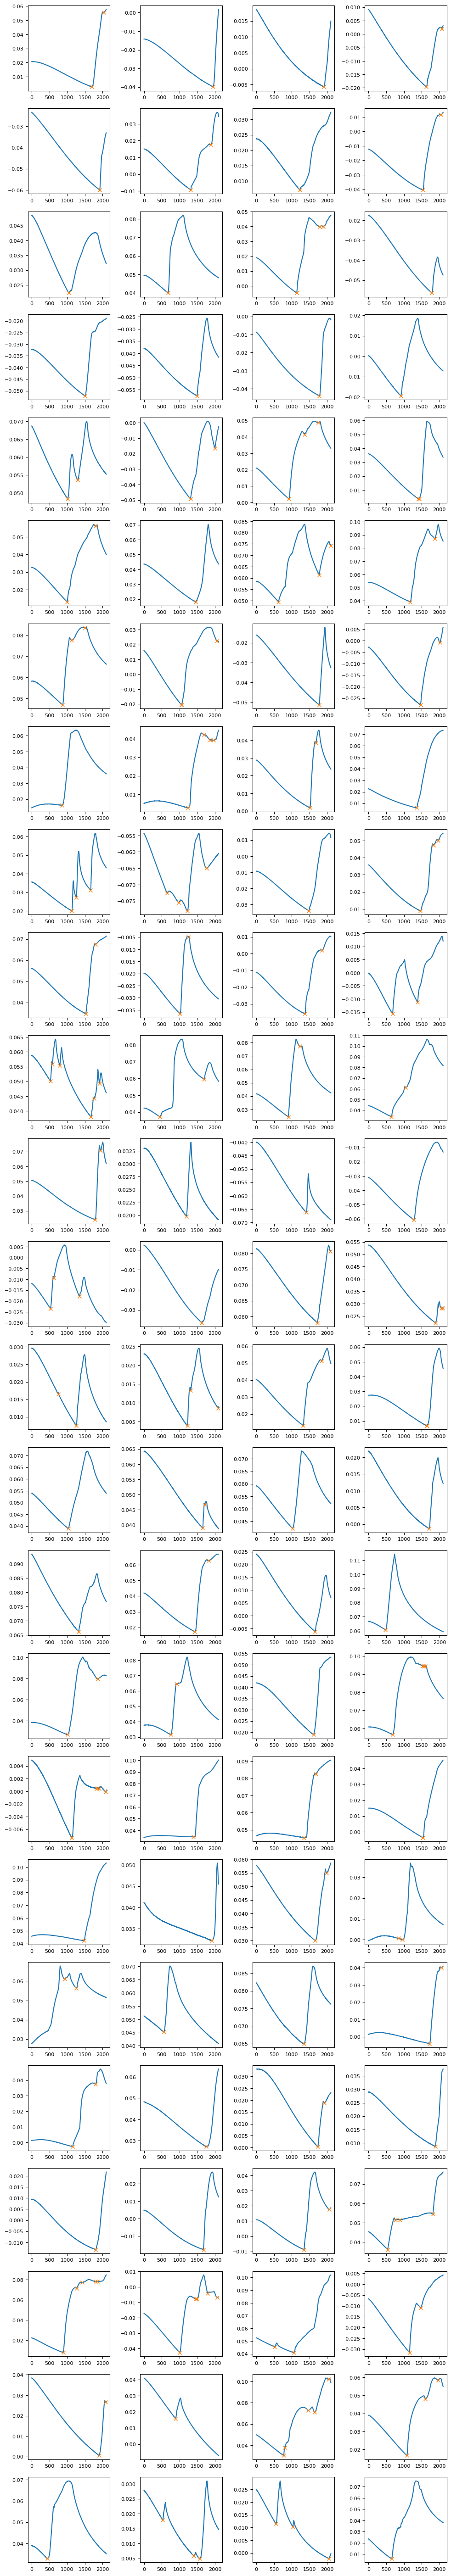

In [13]:
"""# plotting tests of interest with peaks
i = 100
j = 200

target_indices = list(range(len(rf_tests[i:j]))) # all
plot_waveforms(target_indices, rf_tests[i:j], rf_peaks[i:j], "P4")"""

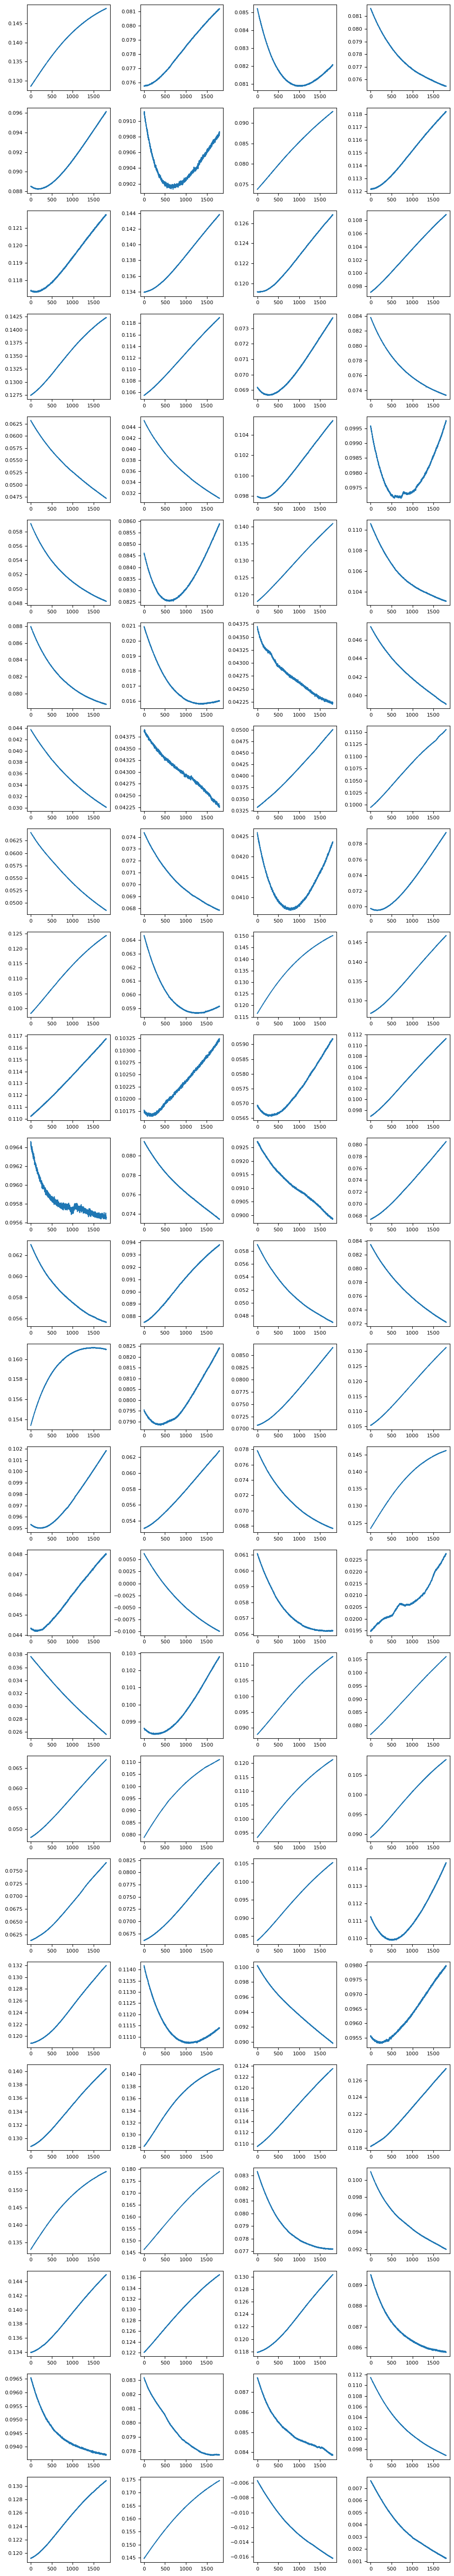

In [34]:
"""# plotting differences between channel waveforms
plot_channel_diff(target_indices, rf_tests[i:j])"""

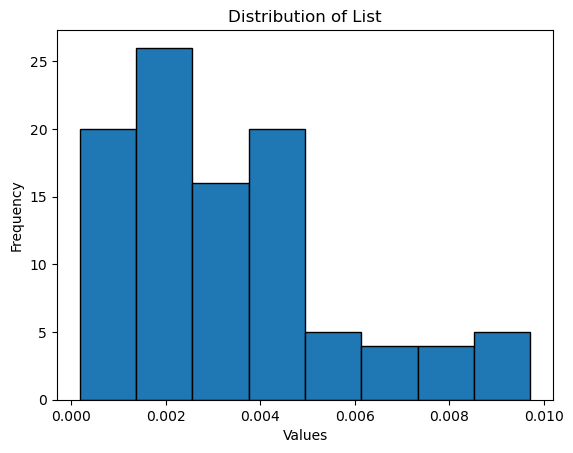

In [38]:
"""# evaluating noisiness of channel difference signals
std = compute_noise(target_indices, rf_tests[i:j])

# plotting distribution of std
plt.hist(std, bins='auto', edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of List')

# show the plot
plt.show()"""

In [25]:
"""
# grabbing indices of mislabelled tests
sub_idx = [12, 18, 61, 77]
sub_idx = [idx-1 for idx in sub_idx]

mislabelled_idx = []
for idx in sub_idx:
    mislabelled_idx.append(rb_pass_idx[idx])
    
print(mislabelled_idx)

for idx in mislabelled_idx:
    print(rb_tests[idx].ID)
"""

'\n# grabbing indices of mislabelled tests\nsub_idx = [12, 18, 61, 77]\nsub_idx = [idx-1 for idx in sub_idx]\n\nmislabelled_idx = []\nfor idx in sub_idx:\n    mislabelled_idx.append(rb_pass_idx[idx])\n    \nprint(mislabelled_idx)\n\nfor idx in mislabelled_idx:\n    print(rb_tests[idx].ID)\n'

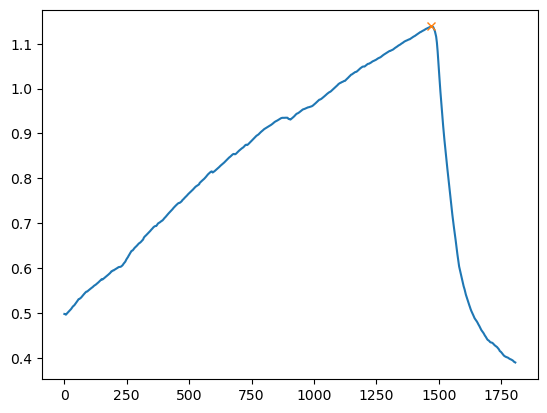

[1468]
1
[1468]
1


In [40]:
"""
# investigating individual samples
test_idx = 6
sample = rb_tests[test_idx]
    
# check for peaks and/or valleys
P4_array = np.array(sample.P4)
peaks = rb_peaks[test_idx]
plt.plot(P4_array)
plt.plot(peaks, P4_array[peaks], "x")
plt.show()

print(peaks)
print(len(peaks))

print(rb_peaks[test_idx])
print(len(rb_peaks[test_idx]))
"""

In [6]:
# define the polynomial function to fit
def poly_func(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


# fit error to polynomial curve
def fit_poly(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = int((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(poly_func, x, y)
    y_fit = poly_func(x, *popt) # unpacks tuple into the 6 coefficients rather than passing an array

    return x, y, y_fit, popt # ADDED POPT TO SEE COEFFICIENTS


# define the linear function to fit
def lin_func(x, a, b):
    return a*x + b


# fit data to linear curve for one test
def fit_lin(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = int((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(lin_func, x, y)
    y_fit = lin_func(x, *popt) # unpacks tuple into the 2 coefficients rather than passing an array

    return x, y, y_fit, popt


def plot_fit(x_list, y_list, y_fit_list):
    n_plots = len(x_list)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for idx, (x, y, y_fit) in enumerate(zip(x_list, y_list, y_fit_list)):
        axs[idx].scatter(x, y, marker='o', s=0.05, label='Data')
        axs[idx].plot(x, y_fit, color='red', label='Fit')
        axs[idx].tick_params(axis='both', which='major', labelsize=8)
        
    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
    
def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared

In [8]:
### simulating pipeline filtering for normal vs ref failure classification
print(len(rf_tests))
mislabelled_IDs = [9938538,10156680,9925364,9925365,9925366,9925372,9930007,9936122,9938269,9938374,9940434,9940579,9948565,
                   9948808,9976467,9979141,9990178,9990296,9938596,9987550,10016424,10017306,10017317,10018494,10018535,10018609,
                   10019934,10020102,10020118,10032447,10037336,10037557,10045983,10050257,10052220,10053192,10053197,10055126,
                   10055522,10092143,10093215,10093219,10093244,10099978,10099988,10141397,10141399,10144297,10156758,10161679,
                   10161848,10162232,10209158,10209160,10209340,10209347,10209351,10209615,10210158,10210166,10212789,10212816,
                   10216677,10216792,10216948,10217218,10217373,10222336,10222367,10230372,10230503,10230647,10230736,10230861,
                   10231582,10235570,10300110,10300128,10300436,10303517,10324466,10324863,10326050,10326154,10331129,10331645,
                   10331649,10331655,10331682,10351954,10352005,10353310,10353757,10353844,10366986,10367003,10367312,10367314,
                   10368483,10368573,10368599,10371167,10393545,10393678,10393679,10393684,10393688,10398049,10399520,10399548,
                   10399592,10399603,10399606,10444796,10444826,10444850,10445377,10445390,10445467,10447550,10447578,10450845,
                   10473452,10473483,10473498,10474543,10474550,10474802,10477552,10477668,10477673,10477844,10477883,10477893,
                   10479485,10479621,10516528,10516801,10517397,10517537,10521862,10521874,10522228,10522324,10538397,10539869,
                   10540000,10540011,10543357,10543456,10545373,10566923,10566988,10570600,10572212,10572235,10572578,10572595,
                   10612613,10612786,10616681,10617184,10619471,10619563,10084427,10318971,10345699,10156868,10318959,10345692,
                   10637720,10639340,10639356,10639375,10658664,10658673,10658679,10658695,10658707,10661264,10661379,10679756,
                   10682362,10682367,10682785,10730144,10731308,10744370,10744443,10744533,10744534,10751336,10766517]

# cleaning up
to_remove = []
for _, test in enumerate(rf_tests):
    # relabelling mislabelled tests
    if test.ID in mislabelled_IDs:
        to_remove.append(test)
        
rf_tests = [test for test in rf_tests if test not in to_remove]
print(len(rf_tests))

# finding peaks in ref failures
rf_peaks = flag_peaks(rf_tests)

targets = []
for idx, peak_list in enumerate(rf_peaks):
    if (0 < len(peak_list) <= 5):
        targets.append(idx)
        
print(len(targets))

2706
2696
2660


In [7]:
### fitting ref failures to polynomial curves
x_list = []
y_list = []
y_fit_list = []
coef_list = []

# splicing
i = 200
j = 300

for idx, _ in enumerate(rf_tests):
# for idx in targets:
    x, y, y_fit, coef = fit_poly(idx, rf_tests)
    x_list.append(x)
    y_list.append(y)
    y_fit_list.append(y_fit)
    coef_list.append(coef)

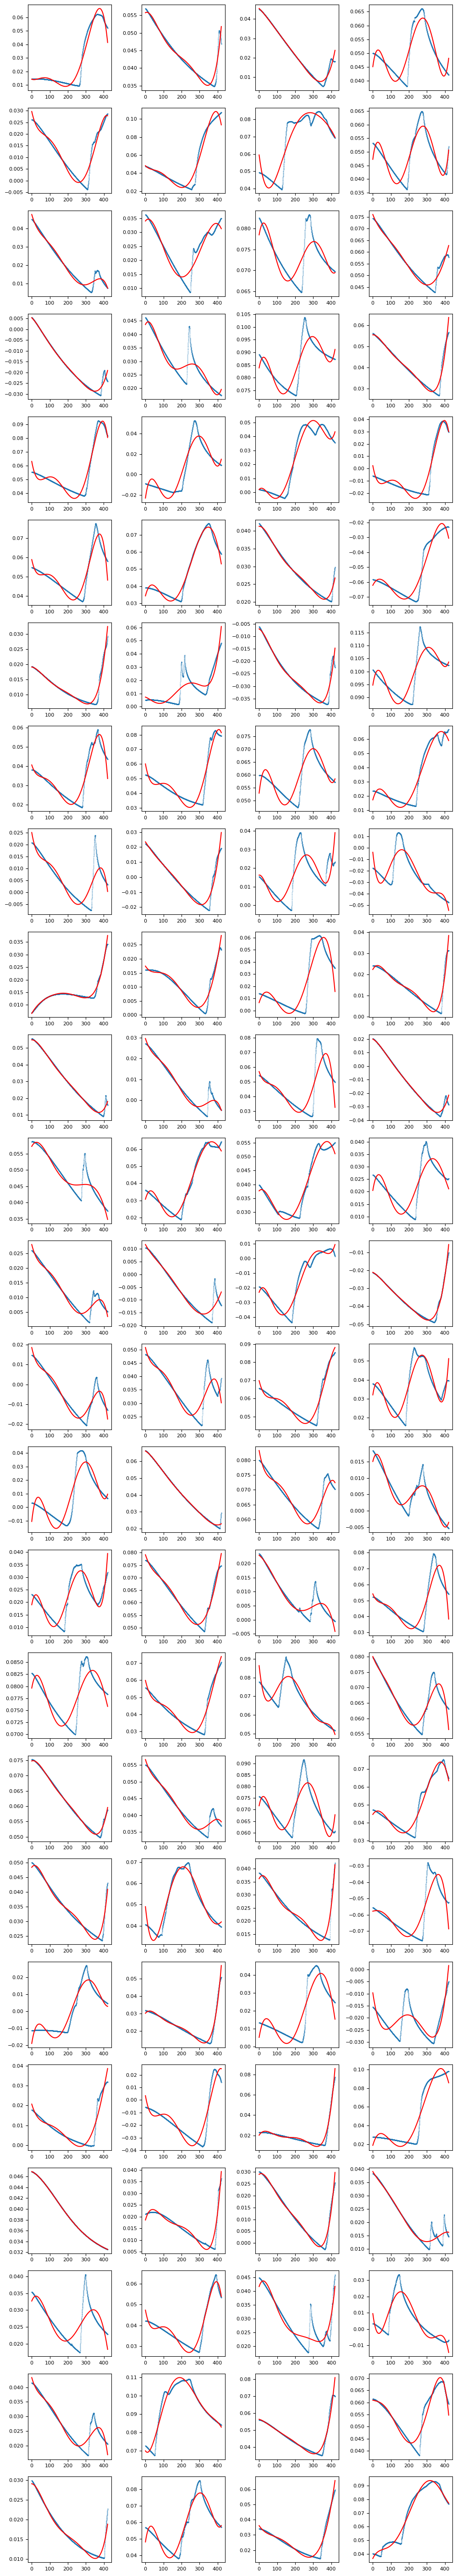

In [16]:
### plotting ref failures with fit functions
plot_fit(x_list, y_list, y_fit_list)

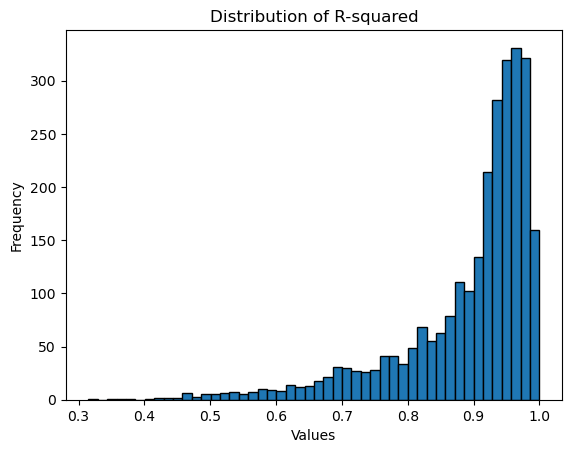

In [8]:
### computing R-squared values to evaluate fit
rs_list = []

for y, y_fit in zip(y_list, y_fit_list):
    rs_list.append(compute_residuals(y, y_fit))
    
rs_list.sort() # DO NOT SORT ON FIRST RUN

"""for r_squared in rs_list:
    print(f"R-squared: {r_squared:.4f}")"""

# plotting distribution of R-squared
plt.hist(rs_list, bins='auto', edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of R-squared')

# show the plot
plt.show()

In [56]:
# for comparing to ref bubbles
rs_to_remove = []
print(len(rs_list))

for idx, coef in enumerate(coef_list):
    if coef[0] < 0:
        rs_to_remove.append(rs_list[idx])
        
rs_list = [rs for rs in rs_list if rs not in rs_to_remove]
print(len(rs_list))

2660
1718


In [68]:
limit = []
for rs in rs_list:
    if rs > 0.9975:
        limit.append(rs)
        
print(len(limit))
print(len(rs_list))

7
2660


In [62]:
print(np.mean(rs_list))
print(np.median(rs_list))

0.36811501267267027
0.32776290188365836


In [63]:
# calculating median absolute deviation
median = np.median(rs_list)
MAD = np.median(np.abs(rs_list - median))
print(MAD)

0.22379516246677533


In [64]:
# for samples failing the threshold, how far are they from median R-squared?
# and how close are they to the threshold?
median = np.median(rs_list)
dist_med = []
# dist_threshold = []
for rs in rs_list:
    if rs > 0.9500:
        dist_med.append(rs - median)
        # dist_threshold.append(rs - 0.9975)

# mean_deviation = np.mean(deviations)
# print(mean_deviation)

median_dist_med = np.median(dist_med)
print(median_dist_med)

# median_dist_threshold = np.median(dist_threshold)
# print(median_dist_threshold)

0.6368598445240077
